# Linear Regression Model for Predicting House Prices

### Import Library

In [36]:
import numpy as np 
import pandas as pd
from math import sqrt
import seaborn as sns
from scipy.stats import skew
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Exploratory Data Analysis

In [37]:
# load the datasets into dataframe
train = pd.read_csv('train.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [38]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [39]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [40]:
numeric_cols = train.select_dtypes(include = [np.number])
corr = numeric_cols.corr()
print ('The Most Correlated Features with SalePrice:'), print (corr['SalePrice'].sort_values(ascending = False)[:10], '\n')
print ('The Most Uncorrelated Features with SalePrice:'), print (corr['SalePrice'].sort_values(ascending = False)[-5:])

The Most Correlated Features with SalePrice:
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64 

The Most Uncorrelated Features with SalePrice:
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


(None, None)

### Outlier

Text(0.5, 1.0, 'SalePrice VS GarageArea')

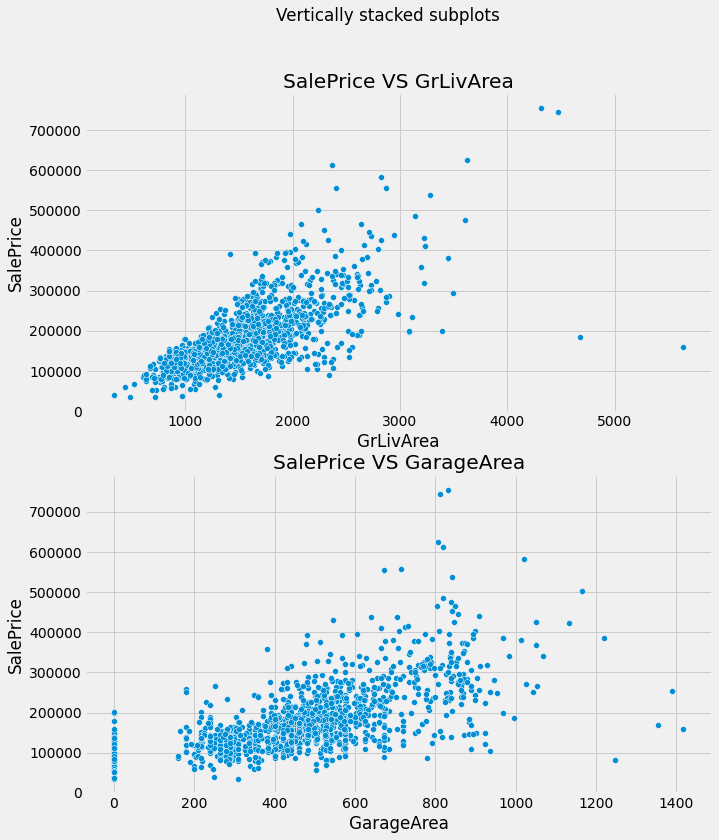

In [41]:
fig, axes = plt.subplots(2, 1,  figsize=(10, 12))
fig.suptitle('Vertically stacked subplots')
sns.scatterplot(x = train['GrLivArea'], y = train['SalePrice'] , ax=axes[0])
axes[0].set_title('SalePrice VS GrLivArea')

sns.scatterplot(x = train['GarageArea'], y = train['SalePrice'], ax=axes[1])
axes[1].set_title('SalePrice VS GarageArea')


GrLivArea dan GarageArea memiliki outlier

## Data Preprocessing

In [42]:
# remove GrLivArea outliers
train= train[train['GrLivArea'] < 4500]
# remove GarageArea outliers
train= train[train['GarageArea'] < 1200]

In [43]:
# cek missing values
print ('Total missing values in train set', sum(train.isna().sum()))


Total missing values in train set 6941


In [44]:
# drop columns with percentage of missing values > 80%
train_percentage = train.isnull().sum() / train.shape[0]
print (train_percentage[train_percentage > 0.80])
train = train.drop(train_percentage[train_percentage > 0.80].index, axis = 1)

Alley          0.937414
PoolQC         0.995873
Fence          0.806740
MiscFeature    0.963549
dtype: float64


In [45]:
# encode categorical variables
le = preprocessing.LabelEncoder()
for name in train.columns:
    if train[name].dtypes == 'O':
        train[name] = train[name].astype(str)
        le.fit(train[name])
        train[name] = le.transform(train[name])

Ada banyak cara untuk menangani nilai NaN, yaitu diisi dengan mean atau median, namun string tidak dapat dirata-ratakan atau median-ed. Salah satu cara untuk mengisi nilai yang hilang adalah dengan memasukkan nilai-nilai yang hilang ini sesuai dengan probabilitasnya terjadi dalam himpunan data untuk menghindari imputasi bernilai tunggal yang memengaruhi kualitas inferensi dan prediksi.

In [46]:
# fill missing values based on probability of occurrence
for column in train.columns:
    null_vals = train.isnull().values
    a, b = np.unique(train.values[~null_vals], return_counts = 1)
    train.loc[train[column].isna(), column] = np.random.choice(a, train[column].isnull().sum(), p = b / b.sum())

In [47]:
# apply log transformation to reduce skewness over .75 by taking log(feature + 1)
skewed_train = train.apply(lambda x: skew(x.dropna()))
skewed_train = skewed_train[skewed_train > .75]
train[skewed_train.index] = np.log1p(train[skewed_train.index])

## Modelling

In [48]:
#Defisinisikan X dan Y
X = train.drop(['SalePrice', 'Id'], axis = 1)
y = train['SalePrice']

#Train test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 1)

Split the data into training and testing set using scikit-learn train_test_split function. We are using 60% of the data for training and 40% for testing, train_test_split() returns four objects:

- **X_train**: the subset of our features used for training
- **X_test**: the subset which will be our ‘hold-out’ set – what we’ll use to test the model
- **y_train**: the target variable SalePrice which corresponds to X_train
- **y_test**: the target variable SalePrice which corresponds to X_test

Now we will import the linear regression class, create an object of that class, which is the linear regression model.

### Linear Regression

In [49]:
 # create linear regression object
reg = linear_model.LinearRegression()
 
# train the model using the training sets
reg.fit(X_train, y_train)
 
# regression coefficients
print('Coefficients: ', reg.coef_)

# regression intercept
print('Intercept: ', reg.intercept_)

Coefficients:  [-4.85024518e-03 -3.34296101e-02  4.05923372e-03  9.65395143e-02
  6.54293946e-02 -5.41926079e-04 -8.51025915e-04 -1.48315457e-01
 -2.09889240e-03 -8.73382325e-03 -1.11615300e-03  4.07895077e-02
  4.42891966e-02  1.87295494e-02  1.59047119e-03  5.68465115e-02
  4.42266006e-02  1.66334551e-03  6.15752315e-04  1.75130234e-02
 -5.51342985e-03 -5.46317921e-03  3.29086979e-03  1.64989564e-02
  1.29107612e-03 -2.01379510e-02  7.02601802e-03  1.98575555e-02
 -1.79774089e-02  1.54814860e-02 -4.23772134e-03 -1.90126882e-03
  6.68955877e-03 -1.00808420e-03 -1.55096745e-03 -7.11618589e-03
  1.03247546e-04 -7.35209394e-02 -7.25360192e-03  4.48442505e-02
 -9.57298592e-03  9.34745214e-02  4.61352373e-03  3.29018749e-03
  3.02229765e-01  4.01927751e-02  1.98956886e-02  1.84213339e-02
  2.53635108e-02 -6.75093296e-03 -2.62134592e-01 -1.80479473e-02
  7.10894805e-03  2.36948086e-02  2.48849569e-02 -4.34442747e-03
  2.30500374e-03  3.72241671e-03 -7.93060888e-04  3.86706937e-02
  4.515916

Variance score: 0.9114757934729354


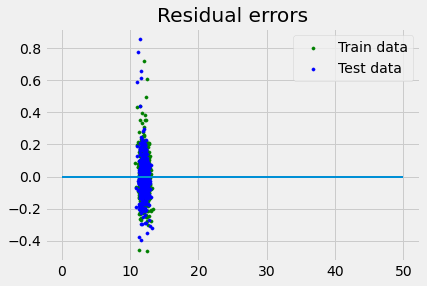

In [50]:
 # variance score: 1 means perfect prediction
print('Variance score: {}'.format(reg.score(X_test, y_test)))
 
# plot for residual error
 
## setting plot style
plt.style.use('fivethirtyeight')
 
## plotting residual errors in training data
plt.scatter(reg.predict(X_train), reg.predict(X_train) - y_train,
            color = "green", s = 10, label = 'Train data')
 
## plotting residual errors in test data
plt.scatter(reg.predict(X_test), reg.predict(X_test) - y_test,
            color = "blue", s = 10, label = 'Test data')
 
## plotting line for zero residual error
plt.hlines(y = 0, xmin = 0, xmax = 50, linewidth = 2)
 
## plotting legend
plt.legend(loc = 'upper right')
 
## plot title
plt.title("Residual errors")
 
## method call for showing the plot
plt.show()

In [51]:
# make predictions based on model
y_pred = reg.predict(X_test)

There are three primary metrics used to evaluate linear models. These are:
* Mean absolute error (MAE)
* Mean squared error (MSE)
* Root mean squared error (RMSE)


In [52]:
print('ACC is:',reg.score(X_test,y_test))
print('MAE is:', mean_absolute_error(y_test, y_pred))
print('MSE is:', mean_squared_error(y_test, y_pred))
print('RMSE is:', sqrt(mean_squared_error(y_test, y_pred)))

ACC is: 0.9114757934729354
MAE is: 0.08513324194615694
MSE is: 0.015000720514899984
RMSE is: 0.12247742859359835


### Ridge Regression

In [53]:
from sklearn.linear_model import Ridge
model = Ridge()
model.fit(X_train, y_train)

# regression coefficients
print('Coefficients: ', model.coef_)

# regression intercept
print('Intercept: ', model.intercept_)

Coefficients:  [-7.25174192e-03 -3.32842110e-02  4.04438363e-03  9.48532139e-02
  4.73642749e-02 -9.40061647e-04 -9.56593904e-04 -4.42099588e-02
 -1.92735005e-03 -6.97660789e-03 -1.17598853e-03  3.98173131e-02
  3.97501544e-02  1.70286380e-02  2.12414614e-03  5.85257647e-02
  4.39593061e-02  1.66960957e-03  6.49205737e-04  1.85272878e-02
 -5.97354602e-04 -5.38052928e-03  3.27549476e-03  1.60166108e-02
  1.23930131e-03 -1.93988265e-02  7.35507310e-03  1.97594409e-02
 -1.83657042e-02  1.48930777e-02 -4.02588617e-03 -2.23431716e-03
  6.64131945e-03 -1.49088724e-03 -1.89732348e-03 -7.40967144e-03
  1.10058265e-04 -6.25978657e-02 -7.42353223e-03  4.79094960e-02
 -9.04542642e-03  1.22115515e-01  8.55208052e-03  5.87013032e-03
  2.43557324e-01  3.92389461e-02  1.71796159e-02  1.96448655e-02
  2.74318452e-02 -5.44329491e-03 -2.00251331e-01 -1.80816556e-02
  7.27211896e-03  2.23762442e-02  2.66591170e-02 -4.49570927e-03
  2.10826607e-03  3.88047756e-03 -1.50146350e-03  3.70334565e-02
  5.062418

In [54]:
# make predictions based on model
y_pred2 = model.predict(X_test)

In [55]:
print('ACC is:', model.score(X_test,y_test))
print('MAE is:', mean_absolute_error(y_test, y_pred2))
print('MSE is:', mean_squared_error(y_test, y_pred2))
print('RMSE is:', sqrt(mean_squared_error(y_test, y_pred2)))

ACC is: 0.9110912864266754
MAE is: 0.08544798274706719
MSE is: 0.015065876509663909
RMSE is: 0.12274313223013297


Text(0.5, 1.0, 'Linear Regression Model')

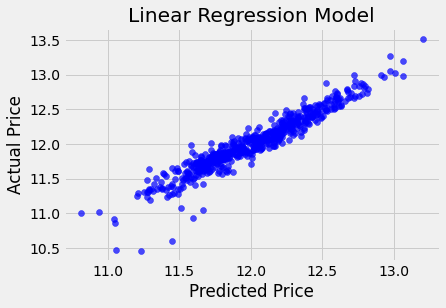

In [56]:
# alpha helps to show overlapping data
plt.scatter(y_pred2, y_test, alpha = 0.7, color = 'b')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')

### Save Model into joblib

In [57]:
import joblib
joblib.dump(model, 'model_lr.pkl')

['model_lr.pkl']

# Classification Models

## Import Library

Train two models: logistic regression and random forest for this data and shows the result & 
evaluation.

In [58]:
import pandas as pd
heart =pd.read_csv("heart.csv")
heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [59]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

df_column = ['Age', 'RestingBP', 'Cholesterol','FastingBS', 'MaxHR', 'Oldpeak']
fig = go.Figure()
for i in df_column:
    fig.add_trace(go.Box(y=heart[i], name=i))
fig.show() 

ImportError: cannot import name 'qualitative' from 'plotly.colors' (c:\Users\ACER\AppData\Local\Programs\Python\Python39\lib\site-packages\plotly\colors.py)

## Data Preprocessing

In [91]:
#Detecting outliers

Q1=heart.quantile(0.25)
Q3=heart.quantile(0.75)

IQR=Q3-Q1


In [92]:
#Definisi deteksi outlier
def outlier_detect(heart, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    return heart[((heart[col] < (q1_col - 1.5 * iqr_col)) |(heart[col] > (q3_col + 1.5 * iqr_col)))]

# ------------------------------------------------
def outlier_detect_normal(heart, col):
    m = heart[col].mean()
    s = heart[col].std()
    return heart[((heart[col]-m)/s).abs()>3]

# ------------------------------------------------
def lower_outlier(heart, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    lower = heart[(heart[col] < (q1_col - 1.5 * iqr_col))]
    return lower

# ------------------------------------------------
def upper_outlier(heart, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    upper = heart[(heart[col] > (q3_col + 1.5 * iqr_col))]
    return upper

# ------------------------------------------------
def replace_upper(heart, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    tmp = 9999999
    upper = q3_col + 1.5 * iqr_col
    heart[col] = heart[col].where(lambda x: (x < (upper)), tmp)
    heart[col] = heart[col].replace(tmp, upper)
    print('outlier replace with upper bound - {}' .format(col)) 
    
# ------------------------------------------------
def replace_lower(heart, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    tmp = 1111111
    lower = q1_col - 1.5 * iqr_col
    heart[col] = heart[col].where(lambda x: (x > (lower)), tmp)
    heart[col] = heart[col].replace(tmp, lower)
    print('outlier replace with lower bound - {}' .format(col)) 

In [93]:
final_numeric_feature = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
for i in range(len(final_numeric_feature)):
    print("IQR => {}: {}".format(final_numeric_feature[i],(outlier_detect(heart[final_numeric_feature],final_numeric_feature[i]).shape[0])))
    print("Z_Score => {}: {}".format(final_numeric_feature[i],(outlier_detect_normal(heart[final_numeric_feature],final_numeric_feature[i]).shape[0])))
    print("********************************")

IQR => Age: 0
Z_Score => Age: 0
********************************
IQR => RestingBP: 0
Z_Score => RestingBP: 0
********************************
IQR => Cholesterol: 0
Z_Score => Cholesterol: 0
********************************
IQR => MaxHR: 0
Z_Score => MaxHR: 0
********************************
IQR => Oldpeak: 0
Z_Score => Oldpeak: 1
********************************


In [94]:
outlier = []
for i in range(len(final_numeric_feature)):
    if outlier_detect(heart[final_numeric_feature],final_numeric_feature[i]).shape[0] !=0:
        outlier.append(final_numeric_feature[i])

outlier

[]

In [95]:
for i in range(len(outlier)):
    replace_upper(heart, outlier[i]) 
    
print("\n**************************************\n")
for i in range(len(outlier)):
    replace_lower(heart, outlier[i])


**************************************



In [96]:
for i in range(len(final_numeric_feature)):
    print("IQR => {}: {}".format(final_numeric_feature[i],(outlier_detect(heart,final_numeric_feature[i]).shape[0])))
    print("Z_Score => {}: {}".format(final_numeric_feature[i],(outlier_detect_normal(heart,final_numeric_feature[i]).shape[0])))
    print("********************************")

IQR => Age: 0
Z_Score => Age: 0
********************************
IQR => RestingBP: 0
Z_Score => RestingBP: 0
********************************
IQR => Cholesterol: 0
Z_Score => Cholesterol: 0
********************************
IQR => MaxHR: 0
Z_Score => MaxHR: 0
********************************
IQR => Oldpeak: 0
Z_Score => Oldpeak: 1
********************************


In [97]:
## Converting Zero Value of Cholesterol to NaN Value
heart.loc[heart['Cholesterol'] == 0,'Cholesterol'] = np.nan
heart.head(5)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289.0,0,172,0.0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
1,49,160,180.0,0,156,1.0,1,1,0,0,...,1,0,0,1,0,1,0,0,1,0
2,37,130,283.0,0,98,0.0,0,0,1,0,...,0,0,0,0,1,1,0,0,0,1
3,48,138,214.0,0,108,1.5,1,1,0,1,...,0,0,0,1,0,0,1,0,1,0
4,54,150,195.0,0,122,0.0,0,0,1,0,...,1,0,0,1,0,1,0,0,0,1


In [98]:
## NaN value of Cholesterol is filled with median value
heart["Cholesterol"] = heart["Cholesterol"].fillna(heart["Cholesterol"].median())
heart["Cholesterol"]

0      289.0
1      180.0
2      283.0
3      214.0
4      195.0
       ...  
913    264.0
914    193.0
915    131.0
916    236.0
917    175.0
Name: Cholesterol, Length: 918, dtype: float64

In [99]:
#We should remove this column 
heart = heart.drop(heart[(heart['RestingBP'] == 0)].index) 

In [100]:
#one hot encoding
heart = pd.get_dummies(heart)
heart.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289.0,0,172,0.0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
1,49,160,180.0,0,156,1.0,1,1,0,0,...,1,0,0,1,0,1,0,0,1,0
2,37,130,283.0,0,98,0.0,0,0,1,0,...,0,0,0,0,1,1,0,0,0,1
3,48,138,214.0,0,108,1.5,1,1,0,1,...,0,0,0,1,0,0,1,0,1,0
4,54,150,195.0,0,122,0.0,0,0,1,0,...,1,0,0,1,0,1,0,0,0,1


In [101]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                918 non-null    int64  
 1   RestingBP          918 non-null    int64  
 2   Cholesterol        918 non-null    float64
 3   FastingBS          918 non-null    int64  
 4   MaxHR              918 non-null    int64  
 5   Oldpeak            918 non-null    float64
 6   HeartDisease       918 non-null    int64  
 7   Sex_F              918 non-null    uint8  
 8   Sex_M              918 non-null    uint8  
 9   ChestPainType_ASY  918 non-null    uint8  
 10  ChestPainType_ATA  918 non-null    uint8  
 11  ChestPainType_NAP  918 non-null    uint8  
 12  ChestPainType_TA   918 non-null    uint8  
 13  RestingECG_LVH     918 non-null    uint8  
 14  RestingECG_Normal  918 non-null    uint8  
 15  RestingECG_ST      918 non-null    uint8  
 16  ExerciseAngina_N   918 non

## Modelling

In [102]:
# defining feature matrix(X) and response vector(y)
X = heart.loc[:, heart.columns != 'HeartDisease']
y = heart["HeartDisease"]

In [103]:
# splitting X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
                                                    random_state=1)

In [104]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train) 
X_test = scaler.fit_transform(X_test)

In [105]:
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)
print("X train :\n")
display(X_train.head())
print("X test :\n")
display(X_test.head())

X train :



,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,0.854167,0.641026,0.473000,1.0,0.338235,0.625000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.250000,0.179487,0.553000,0.0,0.102941,0.375000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.645833,0.230769,0.000000,1.0,0.205882,0.375000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.250000,0.743590,0.958333,0.0,0.470588,0.708333,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.354167,0.615385,0.510333,0.0,0.573529,0.375000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


X test :



,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,0.586957,0.300,0.761000,0.0,0.573643,1.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1,0.543478,0.475,0.507667,0.0,0.410853,0.631579,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,0.434783,0.625,0.707667,0.0,0.434109,1.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.478261,1.000,0.673000,0.0,0.418605,0.526316,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0.695652,1.000,0.000000,0.0,0.248062,0.210526,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


### Logistic Regression

In [106]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression()
log = log.fit(X_train, y_train)

### Random Forest

In [107]:
from sklearn.ensemble import RandomForestClassifier

classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5,
                                       n_estimators=100, oob_score=True)

classifier_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_jobs=-1, oob_score=True, random_state=42)

#### Hyperparameter Tuning

In [108]:
# Hyperparameter Tuning
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}

In [109]:
from sklearn.model_selection import GridSearchCV

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 180 candidates, totalling 720 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 30, 50, 100, 200]},
             scoring='accuracy', verbose=1)

In [110]:
grid_search.best_score_

0.8672246905744209

In [111]:
rf_best = grid_search.best_estimator_
rf_best.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, n_estimators=25,
                       n_jobs=-1, random_state=42)

## Save Model into Joblib

In [112]:
import joblib
joblib.dump(log, 'model_log.pkl')
joblib.dump(classifier_rf, 'model_rf.pkl')
joblib.dump(rf_best, 'model_rf_hyperparameterturning.pkl')

['model_rf_hyperparameterturning.pkl']

## Evaluation

In [113]:
y_log = log.predict(X_test)
y_rf = classifier_rf.predict(X_test)
y_rfbest = rf_best.predict(X_test)

In [114]:
from sklearn.metrics import accuracy_score
print('Accuracy Logistic Regression:', accuracy_score(y_test, y_log))
print('Accuracy Random Forest:', accuracy_score(y_test, y_rf))
print('Accuracy Random Forest with Hyperparameter Turning:', accuracy_score(y_test, y_rfbest))

Accuracy Logistic Regression: 0.8695652173913043
Accuracy Random Forest: 0.8885869565217391
Accuracy Random Forest with Hyperparameter Turning: 0.8831521739130435


In [115]:
from sklearn.metrics import precision_score
print('Precision score Logistic Regression :', precision_score(y_test, y_log, average='macro'))
print('Precision score Random Forest :', precision_score(y_test, y_rf, average='macro'))
print('Precision score Random Forest with Hyperparameter Turning:', precision_score(y_test, y_rfbest, average='macro'))

Precision score Logistic Regression : 0.8651244387618566
Precision score Random Forest : 0.8862079510703365
Precision score Random Forest with Hyperparameter Turning: 0.8805810397553517


In [116]:
from sklearn.metrics import recall_score
print('Recall score Logistic Regression :', recall_score(y_test, y_log, average='macro'))
print('Recall score Random Forest  :', recall_score(y_test, y_rf, average='macro'))
print('Recall score Random Forest with Hyperparameter Turning :',recall_score(y_test, y_rfbest, average='macro'))

Recall score Logistic Regression : 0.8732938136494908
Recall score Random Forest  : 0.8839185286517708
Recall score Random Forest with Hyperparameter Turning : 0.8783249734002128


In [117]:
from sklearn.metrics import confusion_matrix
print('Confusion matrix Logistic Regression :', confusion_matrix(y_test, y_log))
print('Confusion matrix Random Forest :', confusion_matrix(y_test, y_rf))
print('Confusion matrix Random Forest with Hyperparameter Turning :', confusion_matrix(y_test, y_rfbest))

Confusion matrix Logistic Regression : [[137  16]
 [ 32 183]]
Confusion matrix Random Forest : [[131  22]
 [ 19 196]]
Confusion matrix Random Forest with Hyperparameter Turning : [[130  23]
 [ 20 195]]


In [118]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_log, pos_label=1) # pos_label: positive label
print('AUC Logistic Regression:', auc(fpr, tpr))
fpr, tpr, thresholds = roc_curve(y_test, y_rf, pos_label=1) # pos_label: positive label
print('AUC Random Forest:', auc(fpr, tpr))
fpr, tpr, thresholds = roc_curve(y_test, y_rfbest, pos_label=1) # pos_label: positive label
print('AUC Random Forest with Hyperparameter Turning:', auc(fpr, tpr))

AUC Logistic Regression: 0.8732938136494909
AUC Random Forest: 0.8839185286517708
AUC Random Forest with Hyperparameter Turning: 0.8783249734002126


In [119]:
from sklearn.metrics import classification_report
print('Logistic Regression:', classification_report(y_test, y_log))
print('Random Forest:', classification_report(y_test, y_rf))
print('Random Forest with Hyperparameter Turning::', classification_report(y_test, y_rfbest))

Logistic Regression:               precision    recall  f1-score   support

           0       0.81      0.90      0.85       153
           1       0.92      0.85      0.88       215

    accuracy                           0.87       368
   macro avg       0.87      0.87      0.87       368
weighted avg       0.87      0.87      0.87       368

Random Forest:               precision    recall  f1-score   support

           0       0.87      0.86      0.86       153
           1       0.90      0.91      0.91       215

    accuracy                           0.89       368
   macro avg       0.89      0.88      0.88       368
weighted avg       0.89      0.89      0.89       368

Random Forest with Hyperparameter Turning::               precision    recall  f1-score   support

           0       0.87      0.85      0.86       153
           1       0.89      0.91      0.90       215

    accuracy                           0.88       368
   macro avg       0.88      0.88      0.88     

Kesimpulan : 
Model terbaik yang dapat digunakan yaitu **Random Forest** karena memiliki akurasi 88%